In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import  uuid
import cv2
import random


In [5]:
# tennsor flow libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Dense,Conv2D,Flatten,Input,MaxPooling2D

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
pos_path=r'/content/drive/MyDrive/data1/positive'
neg_path=r'/content/drive/MyDrive/data1/negative'
web_path=r'/content/drive/MyDrive/data1/webcam'

In [8]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)

    img = tf.io.decode_jpeg(byte_img)

    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img



In [9]:
anchor_dataset = tf.data.Dataset.list_files(os.path.join(web_path, '*.jpg')).take(400)
pos_dataset = tf.data.Dataset.list_files(os.path.join(pos_path, '*.jpg')).take(400)
neg_dataset = tf.data.Dataset.list_files(os.path.join(neg_path, '*.jpg')).take(400)

In [10]:
positives = tf.data.Dataset.zip((anchor_dataset, pos_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_dataset)))))
negatives = tf.data.Dataset.zip((anchor_dataset, neg_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor_dataset)))))
data = positives.concatenate(negatives)

In [11]:
 sample=data.as_numpy_iterator()
 sample.next()

(b'/content/drive/MyDrive/data1/webcam/975e322b-4cde-11ef-883b-c4c6e60ed92d.jpg',
 b'/content/drive/MyDrive/data1/positive/c5cf224f-4cdf-11ef-a2d7-c4c6e60ed92d.jpg',
 1.0)

In [12]:
def preprocess_twin(anchor_img, validation_img, label):
    return (preprocess(anchor_img),preprocess(validation_img),label)

In [13]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [14]:
len(data)


800

In [15]:
#train data
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [16]:
#test data
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [17]:
def make_embedding():
    inp=Input(shape=(100,100,3),name='input_img')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [18]:
embedding=make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [19]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)

        return tf.math.abs(input_embedding - validation_embedding)

In [20]:
def make_siamese_model():

    input_image = Input(name='input_img', shape=(100,100,3))

    validation_image = Input(name='validation_img', shape=(100,100,3))

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [21]:
siamese_model=make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [22]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [23]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [24]:
checkpoint_dir = '/content/drive/My Drive/data1/training_checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [29]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:

        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [30]:
from tensorflow.keras.metrics import Precision, Recall

In [31]:
def train(data, EPOCHS):

    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        r = Recall()
        p = Precision()


        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [72]:
EPOCHS=50
train(train_data, EPOCHS)


 Epoch 1/50
35/35 [==============================] - 10s 297ms/step
1.281504e-06 1.0 1.0

 Epoch 2/50
35/35 [==============================] - 11s 309ms/step
2.9057298e-07 1.0 1.0

 Epoch 3/50
35/35 [==============================] - 11s 326ms/step
2.4028402e-06 1.0 1.0

 Epoch 4/50
35/35 [==============================] - 11s 307ms/step
2.6301832e-05 1.0 1.0

 Epoch 5/50
35/35 [==============================] - 9s 269ms/step
3.049172e-05 1.0 1.0

 Epoch 6/50
35/35 [==============================] - 11s 324ms/step
1.8738418e-06 1.0 1.0

 Epoch 7/50
35/35 [==============================] - 11s 299ms/step
1.0904174e-05 1.0 1.0

 Epoch 8/50
35/35 [==============================] - 11s 322ms/step
8.419171e-07 1.0 1.0

 Epoch 9/50
35/35 [==============================] - 11s 309ms/step
4.1463145e-06 1.0 1.0

 Epoch 10/50
35/35 [==============================] - 11s 322ms/step
3.0282634e-05 1.0 1.0

 Epoch 11/50
35/35 [==============================] - 12s 331ms/step
2.0645186e-05 1.0 1.0



In [68]:
  test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [69]:
y_hat = siamese_model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

1/1 [==============================] - 0s 22ms/step


[0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]

In [70]:
y_true

array([0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.],
      dtype=float32)

face detected


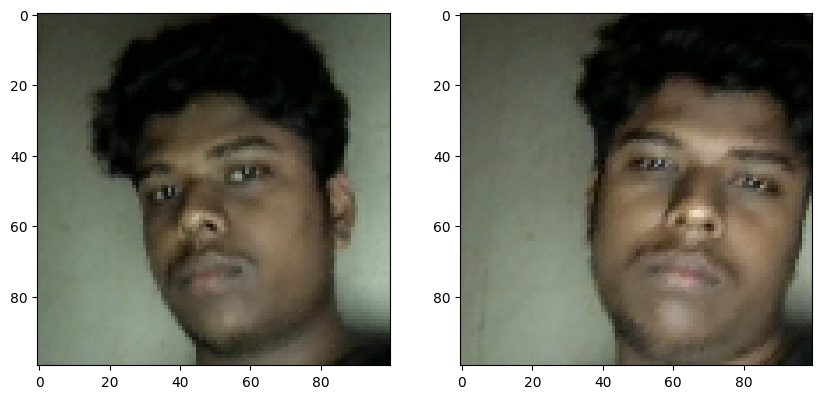

face not detected


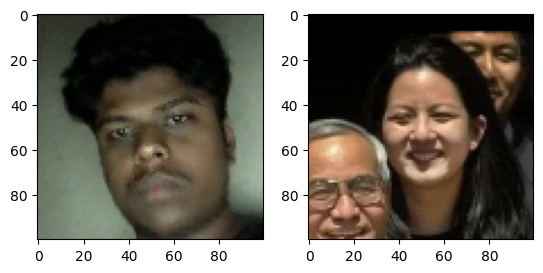

face detected


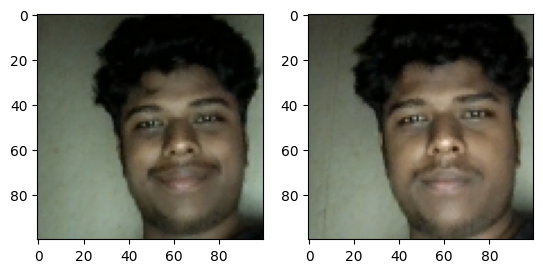

face not detected


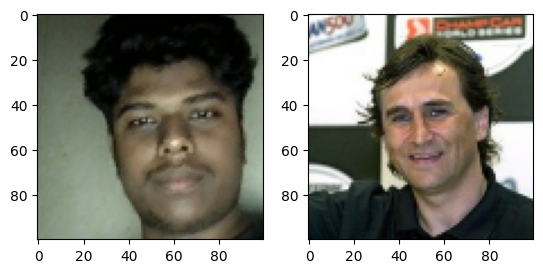

In [73]:
plt.figure(figsize=(10,8))
for i in range (4,8):
  if y_true[i]==y_hat[i] and y_hat[i]==1:
   print('face detected')
  else: print('face not detected')

  plt.subplot(1,2,1)
  plt.imshow(test_input[i])

  plt.subplot(1,2,2)
  plt.imshow(test_val[i])

  plt.show()